In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import warnings

warnings.filterwarnings('ignore')

In [76]:
scores_df = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/season_data.csv')
playoff_scores_df = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/playoff_data.csv')
real_elo = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/nhl_elo.csv')

In [77]:
scores_df.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season
0,2000-10-04,Colorado Avalanche,2.0,Dallas Stars,2.0,1,2001
1,2000-10-05,Ottawa Senators,4.0,Boston Bruins,4.0,1,2001
2,2000-10-05,Chicago Blackhawks,2.0,Buffalo Sabres,4.0,0,2001
3,2000-10-05,Detroit Red Wings,4.0,Calgary Flames,3.0,0,2001
4,2000-10-05,Vancouver Canucks,3.0,Philadelphia Flyers,6.0,0,2001


## Game Result Elo Adjustment

In [78]:
first_yr = scores_df[scores_df['Season'] == 2001]
Teams = first_yr['Home'].unique().tolist()

team_changes = {
    'Atlanta Thrashers': 'Winnipeg Jets',
    'Phoenix Coyotes': 'Arizona Coyotes',
    'Mighty Ducks of Anaheim': 'Anaheim Ducks'
    # Add more mappings as needed
}

K = 6

In [79]:
def calculate_prob_winning(home_team, away_team, elo_ratings):
    
    Elo_diff_home = elo_ratings[home_team]-elo_ratings[away_team] + 26  #add extra for home-ice advantage   
    #Elo_diff_away = elo_ratings[away_team] - elo_ratings[home_team]
    prob_win_home = 1/(10**(-1*Elo_diff_home/400)+1)
    #prob_win_away = 1/(10**(-1*Elo_diff_away/400)+1)
    prob_win_away = 1 - prob_win_home
    
    return prob_win_home, prob_win_away, Elo_diff_home

In [80]:
def margin_of_victory(home_goals, away_goals):
    
    mov = abs(home_goals - away_goals)
    mov_mult = 0.6686*np.log(mov)+0.8048
    
    return mov_mult

In [81]:
# Function to update ELO ratings after a game -- Could add input for elo_ratings dictionary 
def update_game_elo(home_team, away_team, home_goals, away_goals, season, df, idx, elo_ratings):
    
    # Map old team names to new ones
    home_team = team_changes.get(home_team, home_team)
    away_team = team_changes.get(away_team, away_team)
    
    #print('Home team is ' + str(home_team))
    #print('Away team is ' + str(away_team))

    if home_team not in elo_ratings:
        # New teams added past a certain year start with a different ELO rating
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

     # Calculate the probability of winning the game for each team
    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(home_team, away_team, elo_ratings)
    
    # Update DataFrame values
    df.at[idx, 'EloDiffHome'] = Elo_diff_home
    df.at[idx, 'EloDiffAway'] = -1 * Elo_diff_home
    df.at[idx, 'WinProbHome'] = home_prob
    df.at[idx, 'WinProbVis'] = away_prob
    
     # Update Pregame Favorite Multiplier
    if home_goals > away_goals:
        home_win = 1
        #away_win = 0
        winner_elo_diff = Elo_diff_home
    elif home_goals < away_goals:
        home_win = 0
        #away_win = 1
        winner_elo_diff = -1*Elo_diff_home
    else:
        return df, elo_ratings
    
    pre_g_fav_h = home_win - home_prob  
    #pre_g_fav_a = away_win - away_prob  
    
    auto_corr = 2.05/(winner_elo_diff*0.001 + 2.05)
    
     # Adjust ELO shift for margin of victory
    mov_multiplier = auto_corr * margin_of_victory(home_goals, away_goals)
    #print('home goals:' + str(home_goals))
    #print('away goals:' + str(away_goals))
    #print('mult is: ' + str(mov_multiplier))
    
     # Calculate ELO shift based on game result
    elo_shift_h = K * mov_multiplier * pre_g_fav_h 
    #elo_shift_a = K * mov_multiplier * pre_g_fav_a
    #print('elo shift is: ' + str(elo_shift_h))
    
    elo_ratings[home_team] += elo_shift_h
    elo_ratings[away_team] -= elo_shift_h

    return df, elo_ratings

## End of Season Elo Adjustments

In [82]:
def elo_adjuster(df):
    
    # Initialize variables to store the final Elo ratings for the season
    final_elo_ratings = {}
    elo_ratings = {}
    season_weight = 0.8
    average_weight = 0.2
    current_season = None

    # Iterate over seasons and games
    for idx, row in df.iterrows():
        if current_season is None:
            current_season = row['Season']
    
        # Check if the season in the current row is different from the current season
        if row['Season'] != current_season:
            # Save the previous season's Elo ratings and calculate the starting Elo for the new season
            final_elo_ratings[current_season] = dict(elo_ratings)
            elo_ratings = {}  # Reset Elo ratings for the new season

            for team in final_elo_ratings[current_season]:
                prev_season_elo = final_elo_ratings[current_season][team]
                league_avg_elo = sum(final_elo_ratings[current_season].values()) / len(final_elo_ratings[current_season])
                starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
                elo_ratings[team] = round(starting_elo, 2)

            current_season = row['Season']
            
        # Update Elo ratings for the game
        df, elo_ratings = update_game_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], df, idx, elo_ratings)

    # Calculate the final Elo ratings for the last season
    final_elo_ratings[current_season] = dict(elo_ratings)

    return df, elo_ratings, final_elo_ratings

In [83]:
seasons, elo, final_season_elos = elo_adjuster(scores_df)

In [84]:
elo

{'Dallas Stars': 1550.940150407058,
 'Colorado Avalanche': 1584.5444245615597,
 'Boston Bruins': 1646.0070614177143,
 'Ottawa Senators': 1476.0714294103982,
 'Buffalo Sabres': 1483.3405044471829,
 'Chicago Blackhawks': 1390.3846749520826,
 'Calgary Flames': 1517.6920572246158,
 'Detroit Red Wings': 1438.9591928296538,
 'Philadelphia Flyers': 1417.745218787118,
 'Vancouver Canucks': 1484.9400838907918,
 'Arizona Coyotes': 1401.4428712249032,
 'St. Louis Blues': 1486.1607904424352,
 'Edmonton Oilers': 1582.4085250119847,
 'Florida Panthers': 1541.7356119720528,
 'Anaheim Ducks': 1365.7461410120907,
 'Minnesota Wild': 1547.1258135936355,
 'New Jersey Devils': 1529.031110424827,
 'Montreal Canadiens': 1405.9111077584168,
 'Pittsburgh Penguins': 1507.3256629722844,
 'Nashville Predators': 1506.5670113535894,
 'San Jose Sharks': 1382.9101359293545,
 'Tampa Bay Lightning': 1542.7115664597802,
 'New York Islanders': 1513.7599713609845,
 'Washington Capitals': 1477.297610220473,
 'Los Angeles K

### Testing Bounds of Elo

In [11]:
for i in final_season_elos:
    print(f'Max of year {i} is {max(final_season_elos[i].values())}')
    print(f'Min of year {i} is {min(final_season_elos[i].values())}')

Max of year 2001 is 1592.1355800566328
Min of year 2001 is 1407.17797613946
Max of year 2002 is 1594.5595423047896
Min of year 2002 is 1375.969112961436
Max of year 2003 is 1604.4834324889157
Min of year 2003 is 1403.313756619737
Max of year 2004 is 1600.703277602256
Min of year 2004 is 1381.994928786802
Max of year 2006 is 1621.8315238665518
Min of year 2006 is 1385.2106980872195
Max of year 2007 is 1585.809806922114
Min of year 2007 is 1410.9965387341117
Max of year 2008 is 1592.415920121985
Min of year 2008 is 1439.730361842258
Max of year 2009 is 1573.4170823439883
Min of year 2009 is 1398.4869054830074
Max of year 2010 is 1584.8075179050084
Min of year 2010 is 1423.9071652779273
Max of year 2011 is 1591.4007466678427
Min of year 2011 is 1405.5966526380455
Max of year 2012 is 1577.0127514839012
Min of year 2012 is 1431.492209051298
Max of year 2013 is 1591.2735552272406
Min of year 2013 is 1419.8150830163438
Max of year 2014 is 1588.4750973383004
Min of year 2014 is 1394.2163417588

In [16]:
season_weight = 0.8
average_weight = 0.2
max_min = {}
min_ls = []
max_ls = []

for i in final_season_elos:
    start_elo = {}
    for team in final_season_elos[i]:
        prev_season_elo = final_season_elos[i][team]
        league_avg_elo = sum(final_season_elos[i].values()) / len(final_season_elos[i])
        starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
        start_elo[team] = round(starting_elo, 2)
    max_val = max(start_elo.values())
    min_val = min(start_elo.values())
    max_ls.append(max_val)
    min_ls.append(min_val)
    max_min[str(i)+' max'] = max_val
    max_min[str(i)+' min'] = min_val

In [20]:
print(f'The absolute max is {max(max_ls)}')
print(f'The absolute min is {min(min_ls)}')
print(f'The average max is {sum(max_ls) / len(max_ls)}')
print(f'The average min is {sum(min_ls) / len(min_ls)}')

The absolute max is 1616.81
The absolute min is 1388.25
The average max is 1574.9254545454548
The average min is 1419.6604545454543


In [17]:
max_min

{'2001 max': 1573.71,
 '2001 min': 1425.74,
 '2002 max': 1575.65,
 '2002 min': 1400.78,
 '2003 max': 1583.59,
 '2003 min': 1422.65,
 '2004 max': 1580.56,
 '2004 min': 1405.6,
 '2006 max': 1597.47,
 '2006 min': 1408.17,
 '2007 max': 1568.65,
 '2007 min': 1428.8,
 '2008 max': 1573.93,
 '2008 min': 1451.78,
 '2009 max': 1558.73,
 '2009 min': 1418.79,
 '2010 max': 1567.85,
 '2010 min': 1439.13,
 '2011 max': 1573.12,
 '2011 min': 1424.48,
 '2012 max': 1561.61,
 '2012 min': 1445.19,
 '2013 max': 1573.02,
 '2013 min': 1435.85,
 '2014 max': 1570.78,
 '2014 min': 1415.37,
 '2015 max': 1563.92,
 '2015 min': 1389.55,
 '2016 max': 1558.31,
 '2016 min': 1435.69,
 '2017 max': 1578.44,
 '2017 min': 1408.81,
 '2018 max': 1556.13,
 '2018 min': 1422.12,
 '2019 max': 1598.84,
 '2019 min': 1428.51,
 '2020 max': 1574.84,
 '2020 min': 1388.25,
 '2021 max': 1565.67,
 '2021 min': 1425.16,
 '2022 max': 1576.73,
 '2022 min': 1419.51,
 '2023 max': 1616.81,
 '2023 min': 1392.6}

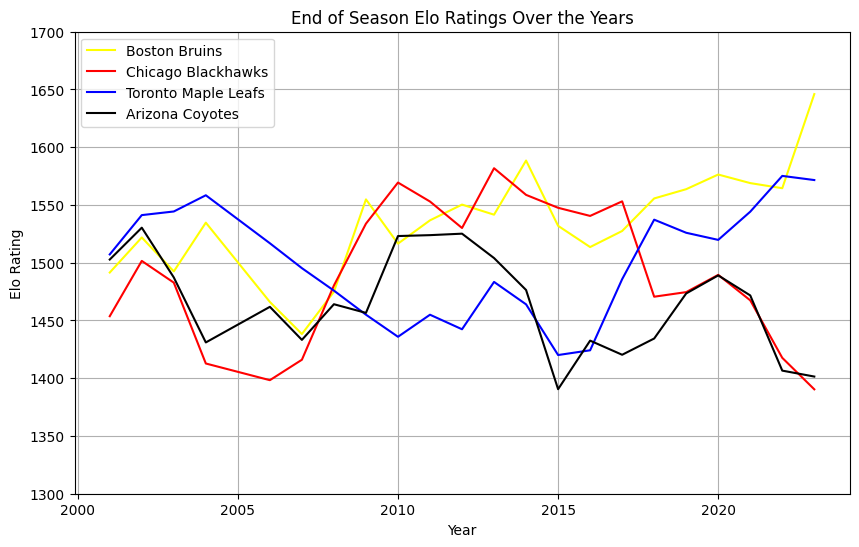

In [19]:
import matplotlib.pyplot as plt

# Choose teams 
selected_teams_colors = {'Boston Bruins': 'yellow', 'Chicago Blackhawks':'red', 'Toronto Maple Leafs':'blue', 'Arizona Coyotes':'black'}

# Plotting
plt.figure(figsize=(10, 6))

for team, color in selected_teams_colors.items():
    elo_values = [final_season_elos[year][team] for year in final_season_elos]
    plt.plot(list(final_season_elos.keys()), elo_values, label=team, color=color)

plt.xlabel('Year')
plt.ylabel('Elo Rating')
plt.title('End of Season Elo Ratings Over the Years')
plt.legend()
plt.grid(True)
plt.ylim(1300, 1700)  # Adjust these values based on your preference
plt.show()

## Building Elo Forecaster Function

In [87]:
#np.random.seed(0)
def forecast_game_elo(home_team, away_team, df, idx, elo_ratings, simulation_wins):

    # Map old team names to new ones
    home_team = team_changes.get(home_team, home_team)
    away_team = team_changes.get(away_team, away_team)

    if home_team not in elo_ratings:
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

     # Calculate the probability of winning the game for each team
    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(home_team, away_team, elo_ratings)

    # Update DataFrame values
    df.at[idx, 'EloDiffHome'] = Elo_diff_home
    df.at[idx, 'EloDiffAway'] = -1 * Elo_diff_home
    df.at[idx, 'WinProbHome'] = home_prob
    df.at[idx, 'WinProbVis'] = away_prob
    
    home_win = np.random.choice([0, 1], p=[away_prob, home_prob])

    # Calculate base scores for the home and away team
    score_home = 2.845905 + 0.003584*Elo_diff_home
    score_away = 2.845905 + 0.003584*(-1)*Elo_diff_home

    conditions_satisfied = 0 

    while conditions_satisfied == 0:
        
        # poisson distribution to shift scores
        poisson_score_home = np.random.poisson(max(0, score_home))
        poisson_score_away = np.random.poisson(max(0, score_away))

        home_goal_diff = poisson_score_home - poisson_score_away
            
        # does it satsify conditions?
        if home_win == 1:
            if home_goal_diff > 0:
                conditions_satisfied = 1
        
        if home_win == 0:
            if home_goal_diff < 0: 
                conditions_satisfied = 1

    #------------------------------------------------------------------------#
    OT_choice = 0
    
    if abs(home_goal_diff) == 1:
        # Decide if the game goes to OT
        OT_choice = np.random.choice(a= [1, 0], p= [0.505, 0.495])
            
    if home_win == 1:
        winner_elo_diff = Elo_diff_home
        simulation_wins[home_team] += 2

        if OT_choice == 1:
            simulation_wins[away_team] += 1
        
    if home_win == 0:
        winner_elo_diff = -1*Elo_diff_home
        simulation_wins[away_team] += 2

        if OT_choice == 1:
            simulation_wins[home_team] += 1

    pre_g_fav_h = home_win - home_prob  
    auto_corr = 2.05/(winner_elo_diff*0.001 + 2.05)
    
    # Adjust ELO shift for margin of victory
    mov_multiplier = auto_corr * margin_of_victory(poisson_score_home, poisson_score_away)

    # Calculate ELO shift based on game result
    elo_shift_h = K * mov_multiplier * pre_g_fav_h 
  
    elo_ratings[home_team] += elo_shift_h
    elo_ratings[away_team] -= elo_shift_h

    df.at[idx, 'G_Home'] = poisson_score_home
    df.at[idx, 'G_Vis'] = poisson_score_away
    df.at[idx, 'OT Ind'] = OT_choice

    #--------------------------------------------------------------------------#

    return df, elo_ratings, simulation_wins

In [88]:
# Iterate over seasons and games
def season_forecaster(df, starting_elo):
        
    # Create a dictionary to track point totals
    simulation_pts = {team: 0 for team in df['Home'].unique()}

    for idx, row in df.iterrows():
        df, starting_elo, simulation_pts = forecast_game_elo(row['Home'], row['Visitor'], df, idx, starting_elo, simulation_pts)  
        
    return df, starting_elo, simulation_pts

In [36]:
def playoff_tracker(simulation_pts, playoffs_made):

    conference_mapping = {
        'East': ['Florida Panthers', 'Toronto Maple Leafs', 'Tampa Bay Lightning', 'Boston Bruins', 'Buffalo Sabres', 'Detroit Red Wings',
                 'Ottawa Senators', 'Montreal Canadiens', 'Carolina Hurricanes', 'New York Rangers', 'Pittsburgh Penguins', 
                 'Washington Capitals', 'New York Islanders', 'Columbus Blue Jackets', 'New Jersey Devils', 'Philadelphia Flyers'],
        'West': ['Colorado Avalanche', 'Minnesota Wild', 'St. Louis Blues', 'Dallas Stars', 'Nashville Predators', 'Winnipeg Jets',
                 'Chicago Blackhawks', 'Arizona Coyotes', 'Calgary Flames', 'Edmonton Oilers', 'Los Angeles Kings', 'Vegas Golden Knights',
                 'Vancouver Canucks', 'San Jose Sharks', 'Anaheim Ducks', 'Seattle Kraken']
    }
    
    # Separate teams into East and West lists
    for conference, teams in conference_mapping.items():
        valid_teams = [i for i in teams if i in simulation_pts]
        sorted_teams = sorted(valid_teams, key=lambda x: simulation_pts[x], reverse=True)

        for team in sorted_teams[:8]:
            playoffs_made[team] += 1

    return playoffs_made

In [89]:
np.random.seed(0)

#scores_df1 = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/season_data.csv')
# For 2023-2024 season forecasting uncomment below
scores_df2 = pd.read_csv('C:/Users/Gabriel/Documents/GitHub/MIE368_PROJECT/team_proj/data/nhl_2023_2024_season.csv')
#scores_df = pd.concat([scores_df1, scores_df2])
df2 = copy.deepcopy(scores_df2)

season_2024 = df2.copy() 
num_simulations = 10000
season_weight = 0.8
average_weight = 0.2

# Create a dictionary to track overall standings
standings = {team: np.zeros(num_simulations) for team in df2['Home'].unique()}

# Create a dictionary to track playoff appearances
playoffs_counter = {team: 0 for team in df2['Home'].unique()}

for simulation in range(num_simulations):
    elo_end = elo  # Creating a deep copy of final_season_elos[2021]

    elo_ratings = {}  # Reset Elo ratings for the new season

    for team in elo_end:
        prev_season_elo = elo_end[team]
        league_avg_elo = sum(elo_end.values()) / len(elo_end)
        starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
        elo_ratings[team] = round(starting_elo, 2)

    season_2024, elo_ratings, simulation_pts = season_forecaster(season_2024, elo_ratings)
    playoffs_counter = playoff_tracker(simulation_pts, playoffs_counter)

    for team, pts in simulation_pts.items():
        standings[team][simulation] = pts


for team, pts in standings.items():
    #print(pts)
    mean_pts = np.mean(pts)
    std_deviation = np.std(pts)
    print(f"{team}: Mean point total = {mean_pts}, Standard Deviation = {std_deviation}")

Pittsburgh Penguins: Mean point total = 91.129, Standard Deviation = 12.275315026507466
Tampa Bay Lightning: Mean point total = 97.0295, Standard Deviation = 12.269508129912952
Vegas Golden Knights: Mean point total = 100.6867, Standard Deviation = 11.943497942813908
Boston Bruins: Mean point total = 114.6342, Standard Deviation = 11.023792013640314
Carolina Hurricanes: Mean point total = 103.8262, Standard Deviation = 11.790589194777333
Calgary Flames: Mean point total = 92.7593, Standard Deviation = 12.281578217395353
Los Angeles Kings: Mean point total = 96.0593, Standard Deviation = 12.02153831712065
Toronto Maple Leafs: Mean point total = 101.7722, Standard Deviation = 11.814385602307045
Vancouver Canucks: Mean point total = 86.9892, Standard Deviation = 12.265874749075175
Buffalo Sabres: Mean point total = 86.4781, Standard Deviation = 12.186563108194205
Columbus Blue Jackets: Mean point total = 68.947, Standard Deviation = 11.955868475355524
Dallas Stars: Mean point total = 99.1

### Finding Runtime Issues

In [19]:
import cProfile

def main():
    season_2022 = copy.deepcopy(scores_df[scores_df['Season'] == 2022])
    num_simulations = 500
    season_weight = 0.7
    average_weight = 0.3

    # Create a dictionary to track overall standings
    standings = {team: np.zeros(num_simulations) for team in df2['Home'].unique()}

    # Create a dictionary to track playoff appearances
    playoffs_counter = {team: 0 for team in df2['Home'].unique()}

    for simulation in range(num_simulations):
        elo_end = copy.deepcopy(final_season_elos[2021])  # Creating a deep copy of final_season_elos[2021]

        elo_ratings = {}  # Reset Elo ratings for the new season

        for team in elo_end:
            prev_season_elo = elo_end[team]
            league_avg_elo = sum(elo_end.values()) / len(elo_end)
            starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
            elo_ratings[team] = round(starting_elo, 2)

        season_2022, elo_ratings, simulation_pts = season_forecaster(season_2022, elo_ratings)
        playoffs_counter = playoff_tracker(simulation_pts, playoffs_counter)

        for team, pts in simulation_pts.items():
            standings[team][simulation] = pts


    for team, pts in standings.items():
        #print(pts)
        mean_pts = np.mean(pts)
        std_deviation = np.std(pts)
        print(f"{team}: Mean point total = {mean_pts}, Standard Deviation = {std_deviation}")

if __name__ == "__main__":
    # Run the profiler
    cProfile.run('main()', sort='cumulative')

         2082 function calls (1890 primitive calls) in 0.005 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.005    0.005 {built-in method builtins.exec}
        1    0.000    0.000    0.005    0.005 <string>:1(<module>)
        1    0.000    0.000    0.005    0.005 3134879366.py:3(main)
        1    0.000    0.000    0.002    0.002 4235467807.py:2(season_forecaster)
        1    0.000    0.000    0.001    0.001 indexing.py:2481(__getitem__)
        1    0.000    0.000    0.001    0.001 indexing.py:2431(__getitem__)
        3    0.000    0.000    0.001    0.000 base.py:3762(get_loc)
        1    0.000    0.000    0.001    0.001 frame.py:3982(_get_value)
        5    0.000    0.000    0.001    0.000 frame.py:3853(__getitem__)
     64/2    0.000    0.000    0.001    0.000 copy.py:128(deepcopy)
        3    0.001    0.000    0.001    0.000 {method 'get_loc' of 'pandas._libs.index.IndexEngine'

KeyError: 0

### Forecast Results

In [85]:
len(season_2022[season_2022['OT Ind'] == 1])/len(season_2022)

0.17530487804878048

In [90]:
mean_pts = pd.DataFrame(columns = ['PTS']).rename_axis('Team')

for team, pts in standings.items():
    mean_pts.loc[team] = [np.mean(pts)]



In [94]:
mean_pts.sort_values(by='PTS', ascending=False, inplace = True)
mean_pts.to_csv('C:/Users/Gabriel/Documents/MIE368/Data/2023_2024_season_projections.csv', index=True)

In [60]:
print("Elo ratings at the end of the simulation")

elo_df = pd.DataFrame(columns = ['Elo']).rename_axis('Team')

for team, elo in elo_ratings.items():
    elo_df.loc[team] = [elo]

elo_df.sort_values(by='Elo', ascending=False)

Elo ratings at the end of the simulation


,Elo
Team,
St. Louis Blues,1587.764744
Vegas Golden Knights,1580.006114
Florida Panthers,1569.468401
Toronto Maple Leafs,1568.412368
Colorado Avalanche,1557.977873
Minnesota Wild,1557.702944
Pittsburgh Penguins,1547.118887
New York Islanders,1544.203893
New York Rangers,1544.172651


In [61]:
final_season_elos[2022]

{'Dallas Stars': 1503.2303905512265,
 'Colorado Avalanche': 1595.910441864351,
 'Boston Bruins': 1564.5113773543303,
 'Ottawa Senators': 1447.7714727082273,
 'Buffalo Sabres': 1438.1486602939285,
 'Chicago Blackhawks': 1417.6440396028033,
 'Calgary Flames': 1562.634961904245,
 'Detroit Red Wings': 1409.9220590200669,
 'Philadelphia Flyers': 1404.0107526135457,
 'Vancouver Canucks': 1502.767612472211,
 'Arizona Coyotes': 1406.5800019869648,
 'St. Louis Blues': 1563.6611183837383,
 'Edmonton Oilers': 1552.6733530203833,
 'Florida Panthers': 1591.236730017949,
 'Anaheim Ducks': 1419.6543663507791,
 'Minnesota Wild': 1569.853125584181,
 'New Jersey Devils': 1410.4647319496478,
 'Montreal Canadiens': 1399.389815598266,
 'Pittsburgh Penguins': 1549.7300127663448,
 'Nashville Predators': 1518.0108034350656,
 'San Jose Sharks': 1421.0856741433977,
 'Tampa Bay Lightning': 1571.8677746004355,
 'New York Islanders': 1502.759514458031,
 'Washington Capitals': 1536.7475211405108,
 'Los Angeles King

In [62]:
print("Elo ratings at the end of the real prior season")

elo_df = pd.DataFrame(columns = ['Elo']).rename_axis('Team')

for team, elo in final_season_elos[2022].items():
    elo_df.loc[team] = [elo]

elo_df.sort_values(by='Elo', ascending=False)

Elo ratings at the end of the real prior season


,Elo
Team,
Colorado Avalanche,1595.910442
Florida Panthers,1591.236730
Carolina Hurricanes,1585.072572
Toronto Maple Leafs,1575.167296
Tampa Bay Lightning,1571.867775
Minnesota Wild,1569.853126
Boston Bruins,1564.511377
St. Louis Blues,1563.661118
Calgary Flames,1562.634962


In [88]:
print("Playoff Probabilities")

playoff_df = pd.DataFrame(columns = ['Playoff Prob']).rename_axis('Team')

playoffs_counter_normalized = {team: count / num_simulations for team, count in playoffs_counter.items()}

for team, playoff_prob in playoffs_counter_normalized.items():
    playoff_df.loc[team] = [playoff_prob]

playoff_df.sort_values(by='Playoff Prob', ascending=False)

Playoff Probabilities


,Playoff Prob
Team,
Vegas Golden Knights,0.8926
Colorado Avalanche,0.8802
Boston Bruins,0.8329
Tampa Bay Lightning,0.8326
Pittsburgh Penguins,0.8032
Carolina Hurricanes,0.7968
Washington Capitals,0.7896
Florida Panthers,0.7460
Toronto Maple Leafs,0.7354


In [13]:
season_2022

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season,EloDiffHome,EloDiffAway,WinProbHome,WinProbVis
23662,2021-10-12,Pittsburgh Penguins,1.0,Tampa Bay Lightning,3.0,0,2022,24.150000,-24.150000,0.534699,0.465301
23663,2021-10-12,Seattle Kraken,2.0,Vegas Golden Knights,1.0,0,2022,82.260000,-82.260000,0.616218,0.383782
23664,2021-10-13,Winnipeg Jets,7.0,Anaheim Ducks,1.0,0,2022,-36.470000,36.470000,0.447707,0.552293
23665,2021-10-13,Chicago Blackhawks,1.0,Colorado Avalanche,0.0,0,2022,100.820000,-100.820000,0.641152,0.358848
23666,2021-10-13,Vancouver Canucks,6.0,Edmonton Oilers,1.0,0,2022,72.510000,-72.510000,0.602861,0.397139
...,...,...,...,...,...,...,...,...,...,...,...
24969,2022-04-29,San Jose Sharks,2.0,Seattle Kraken,4.0,0,2022,75.722038,-75.722038,0.607280,0.392720
24970,2022-04-29,Vegas Golden Knights,1.0,St. Louis Blues,5.0,0,2022,13.081857,-13.081857,0.518817,0.481183
24971,2022-04-29,Boston Bruins,5.0,Toronto Maple Leafs,2.0,0,2022,-47.719030,47.719030,0.431755,0.568245
24972,2022-04-29,Calgary Flames,2.0,Winnipeg Jets,4.0,0,2022,116.315306,-116.315306,0.661406,0.338594


In [53]:
#2018-19 Season
real_scores = np.array([['Tampa Bay Lightning',128],['Boston Bruins',107],['Toronto Maple Leafs',100],
              ['Montreal Canadiens',96],['Florida Panthers',86],['Buffalo Sabres',76],['Detroit Red Wings',74],
              ['Ottawa Senators',64],['Washington Capitals',104],['New York Islanders',103],['Pittsburgh Penguins',100],
              ['Carolina Hurricanes',99],['Columbus Blue Jackets',98],['Philadelphia Flyers',82],['New York Rangers',78],
              ['New Jersey Devils',72],['Nashville Predators',100],['Winnipeg Jets',99],['St. Louis Blues',99],
              ['Dallas Stars',93],['Colorado Avalanche',90],['Chicago Blackhawks',84],['Minnesota Wild',83],
              ['Calgary Flames',107],['San Jose Sharks',101],['Vegas Golden Knights',93],
              ['Vancouver Canucks',81],['Anaheim Ducks',80],['Edmonton Oilers',79],['Los Angeles Kings',71]])

real_scores = pd.DataFrame(real_scores)
real_scores = real_scores.rename(columns={0:'Team', 1:'PTS'})
real_scores['PTS'] = pd.to_numeric(real_scores['PTS'])

In [42]:
# Dont run multiple times
pts_diff = {}

In [54]:
season_yr = 2019
points_df = pd.merge(mean_pts, real_scores, on='Team')
points_df['Diff'] = points_df['PTS_y']-points_df['PTS_x']
pts_diff[season_yr] = points_df

In [60]:
for season, df in pts_diff.items():
    # Multiply the 'YourColumn' by -1
    df['Diff'] = df['Diff'] * -1

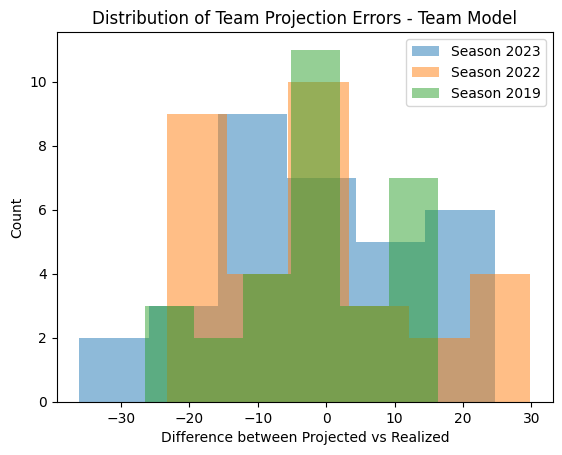

In [74]:
# Create an empty list to store legends
legends = []

# Plot histogram with different color for each season
for season, df in pts_diff.items():
    plt.hist(df['Diff'], bins='auto', alpha=0.5, label=f'Season {season}')
    legends.append(f'Season {season}')

# Show legends
plt.legend(legends)

# Customize plot labels
plt.title('Distribution of Team Projection Errors - Team Model')
plt.xlabel('Difference between Projected vs Realized')
plt.ylabel('Count')

# Show the combined histogram
plt.show()

In [91]:
mean_x = np.mean(points_df['PTS_x'])
std_dev_x = np.std(points_df['PTS_x'])

mean_y = np.mean(points_df['PTS_y'])
std_dev_y = np.std(points_df['PTS_y'])

mean_diff = np.mean(points_df['Diff'])
std_dev_diff = np.std(points_df['Diff'])

test = pd.DataFrame({'Mean':[mean_x, mean_y, mean_diff],'Std Dev':[std_dev_x, std_dev_y, std_dev_diff]})
test.rename({0:'Model', 1:'Actual', 2:'Diff'},axis=0)

,Mean,Std Dev
Model,89.593553,9.530655
Actual,91.437500,18.600970
Diff,12.888903,8.608875


In [92]:
MeanAE = np.sum(points_df['Diff'])/points_df['Diff'].shape[0]
RSS = np.sum((points_df['Diff'])**2)
print(f'The Mean Absolute Error is: {MeanAE}')
print(f'The Residual Sum of Squares is: {RSS}')

The Mean Absolute Error is: 12.888903124999999
The Residual Sum of Squares is: 7687.569514849998


In [93]:
playoffs_2023 = np.array([['Boston Bruins',1],['Toronto Maple Leafs',1],['Tampa Bay Lightning',1],
              ['Florida Panthers',1],['Buffalo Sabres',0],['Ottawa Senators',0],['Detroit Red Wings',0],
              ['Montreal Canadiens',0],['Carolina Hurricanes',1],['New Jersey Devils',1],['New York Rangers',1],
              ['New York Islanders',1],['Pittsburgh Penguins',0],['Washington Capitals',0],['Philadelphia Flyers',0],
              ['Columbus Blue Jackets',0],['Colorado Avalanche',1],['Dallas Stars',1],['Minnesota Wild',1],
              ['Winnipeg Jets',1],['Nashville Predators',0],['St. Louis Blues',0],['Arizona Coyotes',0],
              ['Chicago Blackhawks',0],['Vegas Golden Knights',1],['Edmonton Oilers',1],['Los Angeles Kings',1],
              ['Seattle Kraken',1],['Calgary Flames',0],['Vancouver Canucks',0],['San Jose Sharks',0],['Anaheim Ducks',0]])

playoffs_2023=pd.DataFrame(playoffs_2023)
playoffs_2023=playoffs_2023.rename(columns={0:'Team', 1:'PTS'})

playoffs_2022 = np.array([['Florida Panthers',1],['Toronto Maple Leafs',1],['Tampa Bay Lightning',1],
              ['Boston Bruins',1],['Buffalo Sabres',0],['Detroit Red Wings',0],['Ottawa Senators',0],
              ['Montreal Canadiens',0],['Carolina Hurricanes',1],['New York Rangers',1],['Pittsburgh Penguins',1],
              ['Washington Capitals',1],['New York Islanders',0],['Columbus Blue Jackets',0],['New Jersey Devils',0],
              ['Philadelphia Flyers',0],['Colorado Avalanche',1],['Minnesota Wild',1],['St. Louis Blues',1],
              ['Dallas Stars',1],['Nashville Predators',1],['Winnipeg Jets',0],['Chicago Blackhawks',0],
              ['Arizona Coyotes',0],['Calgary Flames',1],['Edmonton Oilers',1],['Los Angeles Kings',1],
              ['Vegas Golden Knights',0],['Vancouver Canucks',0],['San Jose Sharks',0],['Anaheim Ducks',0],['Seattle Kraken',0]])

playoffs_2022=pd.DataFrame(playoffs_2022)
playoffs_2022=playoffs_2022.rename(columns={0:'Team', 1:'PTS'})

playoffs_2019 = np.array([['Tampa Bay Lightning',1],['Boston Bruins',1],['Toronto Maple Leafs',1],
              ['Montreal Canadiens',0],['Florida Panthers',0],['Buffalo Sabres',0],['Detroit Red Wings',0],
              ['Ottawa Senators',0],['Washington Capitals',1],['New York Islanders',1],['Pittsburgh Penguins',1],
              ['Carolina Hurricanes',1],['Columbus Blue Jackets',1],['Philadelphia Flyers',0],['New York Rangers',0],
              ['New Jersey Devils',0],['Nashville Predators',1],['Winnipeg Jets',1],['St. Louis Blues',1],
              ['Dallas Stars',1],['Colorado Avalanche',1],['Chicago Blackhawks',0],['Minnesota Wild',0],
              ['Calgary Flames',1],['San Jose Sharks',1],['Vegas Golden Knights',1],['Arizona Coyotes',0],
              ['Vancouver Canucks',0],['Anaheim Ducks',0],['Edmonton Oilers',0],['Los Angeles Kings',0]])

playoffs_2019=pd.DataFrame(playoffs_2019)
playoffs_2019=playoffs_2019.rename(columns={0:'Team', 1:'PTS'})

In [1]:
playoff_score = pd.merge(playoff_df, playoffs_2023, on='Team')
playoff_score['PTS'] = pd.to_numeric(playoff_score['PTS'], errors='coerce')
playoff_score

NameError: name 'pd' is not defined

In [97]:
abs(playoff_score['Playoff Prob']- playoff_score['PTS']).mean()

0.36226875000000003